# Generate Event Map and Plot Array Locations
---

In [1]:
%%time
import glob, warnings, mcaap, sys, random, pywt, pickle, os
sys.path.append('/Users/mronacgiannone/Documents/Cardinal')
import cardinal
#-----------------------------------------------------------------------------------------------------------------#
# Command to make all plots interactive
%matplotlib ipympl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from obspy import *
from obspy.core import *
from scipy import signal
from pyproj import Geod; g = Geod(ellps='sphere')

warnings.filterwarnings('ignore')

# Global data directories
winter_data_dir = '/Volumes/Extreme SSD/McAAP/Winter_2021/'
summer_data_dir = '/Volumes/Extreme SSD/McAAP/Summer_2021/'

CPU times: user 2.83 s, sys: 2.99 s, total: 5.82 s
Wall time: 4.3 s


<IPython.core.display.Javascript object>


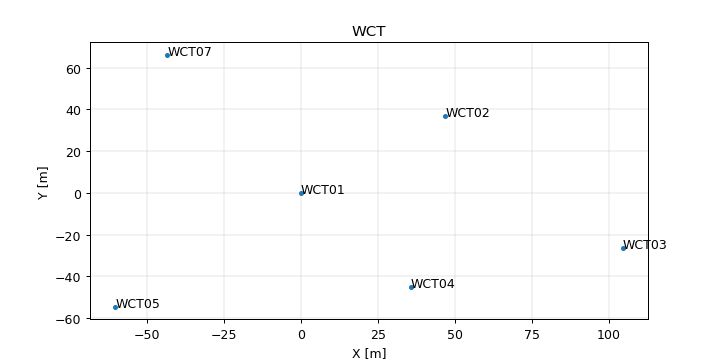

Text(0.5, 1.0, 'WCT')

In [3]:
%matplotlib notebook
st = st_WCT.copy()
X, stnm = cardinal.get_array_coords(st, st[0].stats.station, units='m')
cardinal.plot_array_coords(X, stnm, units='m', figsize=(8,4))
plt.grid(lw=0.25); plt.title('WCT')

---
Plot atmospheric temporal variability

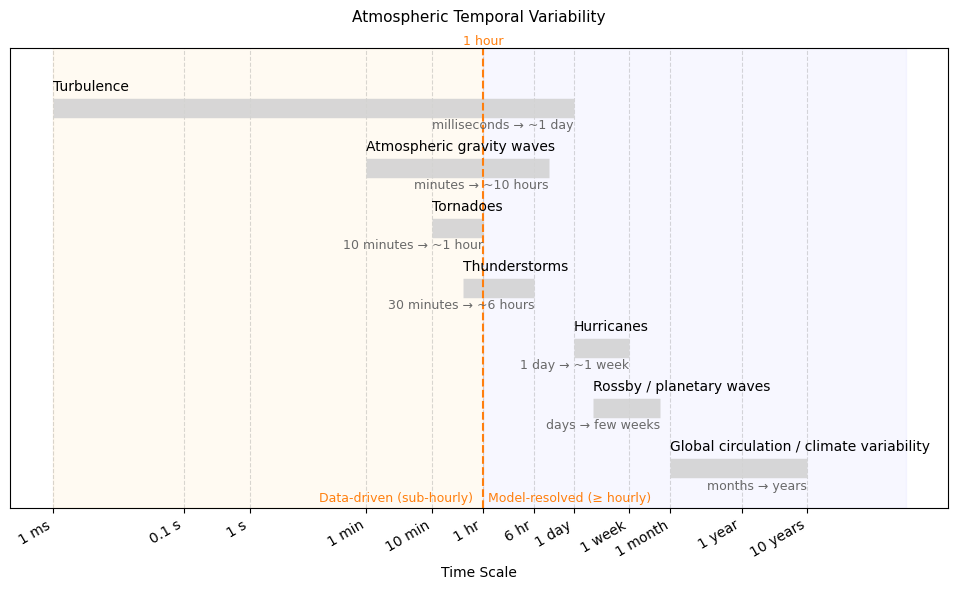

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Processes with characteristic temporal ranges (in seconds)
processes = [
    {
        "name": "Turbulence",
        "t_min_s": 1e-3,          # ~1 ms
        "t_max_s": 24*3600,       # ~1 day
        "label": "milliseconds → ~1 day"
    },
    {
        "name": "Atmospheric gravity waves",
        "t_min_s": 60,            # 1 min
        "t_max_s": 10*3600,       # 10 hr
        "label": "minutes → ~10 hours"
    },
    {
        "name": "Tornadoes",
        "t_min_s": 10*60,         # 10 min
        "t_max_s": 60*60,         # 1 hr
        "label": "10 minutes → ~1 hour"
    },
    {
        "name": "Thunderstorms",
        "t_min_s": 30*60,         # 30 min
        "t_max_s": 6*3600,        # ~6 hr
        "label": "30 minutes → ~6 hours"
    },
    {
        "name": "Hurricanes",
        "t_min_s": 24*3600,       # 1 day
        "t_max_s": 7*24*3600,     # ~1 week
        "label": "1 day → ~1 week"
    },
    {
        "name": "Rossby / planetary waves",
        "t_min_s": 2*24*3600,     # ~2 days
        "t_max_s": 21*24*3600,    # ~3 weeks
        "label": "days → few weeks"
    },
    {
        "name": "Global circulation / climate variability",
        "t_min_s": 30*24*3600,          # ~1 month
        "t_max_s": 10*365*24*3600,      # ~10 years
        "label": "months → years"
    }
]

# increase vertical separation by 1.5x spacing
y_spacing = 1.5
y_pos = np.arange(len(processes))[::-1] * y_spacing

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale('log')

# Draw each process as a horizontal bar
for y, proc in zip(y_pos, processes):
    ax.hlines(
        y,
        proc["t_min_s"],
        proc["t_max_s"],
        linewidth=14,
        color='lightgray',
        alpha=0.9
    )
    
    # Process name (left)
    ax.text(
        proc["t_min_s"],
        y + 0.35,
        proc["name"],
        ha='left',
        va='bottom',
        fontsize=10
    )
    
    # Human-readable lifetime range (right)
    ax.text(
        proc["t_max_s"],
        y - 0.28,
        proc["label"],
        ha='right',
        va='top',
        fontsize=9,
        color='dimgray'
    )

# 1-hour vertical reference line
one_hour = 3600  # seconds
ax.axvline(
    one_hour,
    color='tab:orange',
    linestyle='--',
    linewidth=1.5
)
ax.text(
    one_hour,
    y_pos[0] + 1.5,
    "1 hour",
    ha='center',
    va='bottom',
    color='tab:orange',
    fontsize=9
)

# Region labels (sub-hourly vs hourly+)
ax.text(
    one_hour / 21,
    -0.75,
    "Data-driven (sub-hourly)",
    ha='center',
    va='center',
    color='tab:orange',
    fontsize=9
)
ax.text(
    one_hour * 21,
    -0.75,
    "Model-resolved (≥ hourly)",
    ha='center',
    va='center',
    color='tab:orange',
    fontsize=9
)

# Shaded zones
ax.axvspan(
    1e-3,
    one_hour,
    color='orange',
    alpha=0.05
)
ax.axvspan(
    one_hour,
    1e10,
    color='blue',
    alpha=0.03
)

# Axis styling
ax.set_ylim(-1, max(y_pos) + 1.5)
ax.set_yticks([])
ax.set_xlabel("Time Scale")

# Custom ticks from milliseconds to decades
custom_ticks_s = [
    1e-3, 1e-1, 1, 60, 600, 3600, 6*3600, 24*3600,
    7*24*3600, 30*24*3600, 365*24*3600, 10*365*24*3600
]
custom_labels = [
    "1 ms", "0.1 s", "1 s", "1 min", "10 min", "1 hr", "6 hr",
    "1 day", "1 week", "1 month", "1 year", "10 years"
]
ax.set_xticks(custom_ticks_s)
ax.set_xticklabels(custom_labels, rotation=30, ha='right')

# Title and grid
ax.set_title(
    "Atmospheric Temporal Variability\n",
    fontsize=11
)
ax.grid(axis='x', which='both', linestyle='--', color='gray', alpha=0.3)

plt.tight_layout()
plt.show()



---
Generate event map

In [46]:
import utm, cartopy
#-----------------------------------------------------------------------------------------------------------------------#
import cartopy.crs as ccrs
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patheffects as pe

#-----------------------------------------------------------------------------------------------------------------------#
from matplotlib.colors import ListedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_scalebar(ax, length_km=50, loc=(0.08, 0.06), linewidth=3, text_size=8):
    """
    Simple scale bar for a PlateCarree map. Draws a geodesic-ish bar at the bottom left.
    Length is in km. Location is axes fraction.
    """
    # pick a y at the vertical center of the axes extent for best approximation
    x0, x1, y0, y1 = ax.get_extent(ccrs.PlateCarree())
    y = (y0 + y1) / 2.0
    # convert km to degrees lon at latitude y (approx)
    km_per_deg_lon = 111.32 * np.cos(np.deg2rad(y))
    dlon = length_km / km_per_deg_lon

    x_center = (x0 + x1) / 2.0
    # anchor left of center based on loc[0]
    x_left = x0 + (x1 - x0) * loc[0]
    x_right = x_left + dlon

    ax.plot([x_left, x_right], [y0 + (y1 - y0) * loc[1]]*2,
            color="k", lw=linewidth, transform=ccrs.PlateCarree(),
            solid_capstyle="butt")
    ax.text((x_left + x_right)/2.0, y0 + (y1 - y0) * (loc[1] + 0.02),
            f"{int(length_km)} km", ha="center", va="bottom",
            fontsize=text_size, transform=ccrs.PlateCarree(),
            path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    
def generate_map(ev_lat, ev_lon, EOC_coords, WCT_coords, extent=[-100, -95, 36, 34], projection=ccrs.PlateCarree(), transform=ccrs.Geodetic(), gl_lw=0.5, gl_ls='--', 
                 add_axes_labels=True, draw_labels=True, legend_loc='lower left', title=None, title_size=10.5, markersize=5, legend_fontsize=7.5, lw=0.15, markerscale=2,
                 figsize=(9,6)):

    # Define the figure
    fig, axs = plt.subplots(nrows=1,ncols=1,
                            subplot_kw={'projection': projection},
                            figsize=figsize)
    #-----------------------------------------------------------------------------------------------------------------------#
    # Plotting event
    axs.plot(ev_lon,ev_lat, ls='none', marker='*', mec='k', mfc='yellow', markersize=markersize, markeredgewidth=1, label='McAAP')
    #-----------------------------------------------------------------------------------------------------------------------#
    # Plotting array
    axs.plot(EOC_coords[0], EOC_coords[1], ls='none', marker='^', mec='k', mfc='red', markersize=markersize, markeredgewidth=1, label='EOC')
    axs.plot(WCT_coords[0], WCT_coords[1], ls='none', marker='^', mec='k', mfc='green', markersize=markersize, markeredgewidth=1, label='WCT')
    #-----------------------------------------------------------------------------------------------------------------------#
    axs.set_extent(extent, crs=transform)
    if add_axes_labels == True:
        gl = axs.gridlines(crs=projection, draw_labels=draw_labels, linewidth=0)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.top_labels = False
        gl.right_labels = False
    axs.add_feature(cartopy.feature.LAKES, alpha=0.5)  
    axs.add_feature(cartopy.feature.RIVERS, alpha=0.5)
    axs.add_feature(cartopy.feature.OCEAN, alpha=0.5, color='grey')
    axs.add_feature(cartopy.feature.BORDERS, alpha=0.2) 
    axs.add_feature(cartopy.feature.STATES, alpha=0.5)  
    axs.add_feature(cartopy.feature.LAND, alpha=0.2, color='white') 
    axs.add_feature(cartopy.feature.COASTLINE)
    axs.gridlines(lw=gl_lw, ls=gl_ls)
    plt.legend(loc=legend_loc, fontsize=legend_fontsize, markerscale=markerscale)
    # Add the scale bar
    add_scalebar(axs, length_km=100, loc=(0.5, 0.05))
    
    if title != None:
        axs.set_title(title, size=title_size)
    fig.savefig("map.png", dpi=300, bbox_inches="tight")


In [47]:
%%time
# Read data
_, st_MCA = mcaap.get_beam_for_xcorr(winter_data_dir, array='MCA', julian_day=36, plot=False); st_MCA = st_MCA.remove(st_MCA[-1])
_, st_MCB = mcaap.get_beam_for_xcorr(summer_data_dir, array='MCB', julian_day=202, plot=False); st_MCB = st_MCB.remove(st_MCB[-1])
_, st_EOC = mcaap.get_beam_for_xcorr(winter_data_dir, array='EOCR', julian_day=36, plot=False); st_EOC = st_EOC.remove(st_EOC[-1])
_, st_EOCL = mcaap.get_beam_for_xcorr(winter_data_dir, array='EOCL', julian_day=36, plot=False); st_EOCL = st_EOCL.remove(st_EOCL[-1])
_, st_WCT = mcaap.get_beam_for_xcorr(summer_data_dir, array='WCT', julian_day=202, plot=False); st_WCT = st_WCT.remove(st_WCT[-1])

CPU times: user 89.3 ms, sys: 35.9 ms, total: 125 ms
Wall time: 173 ms


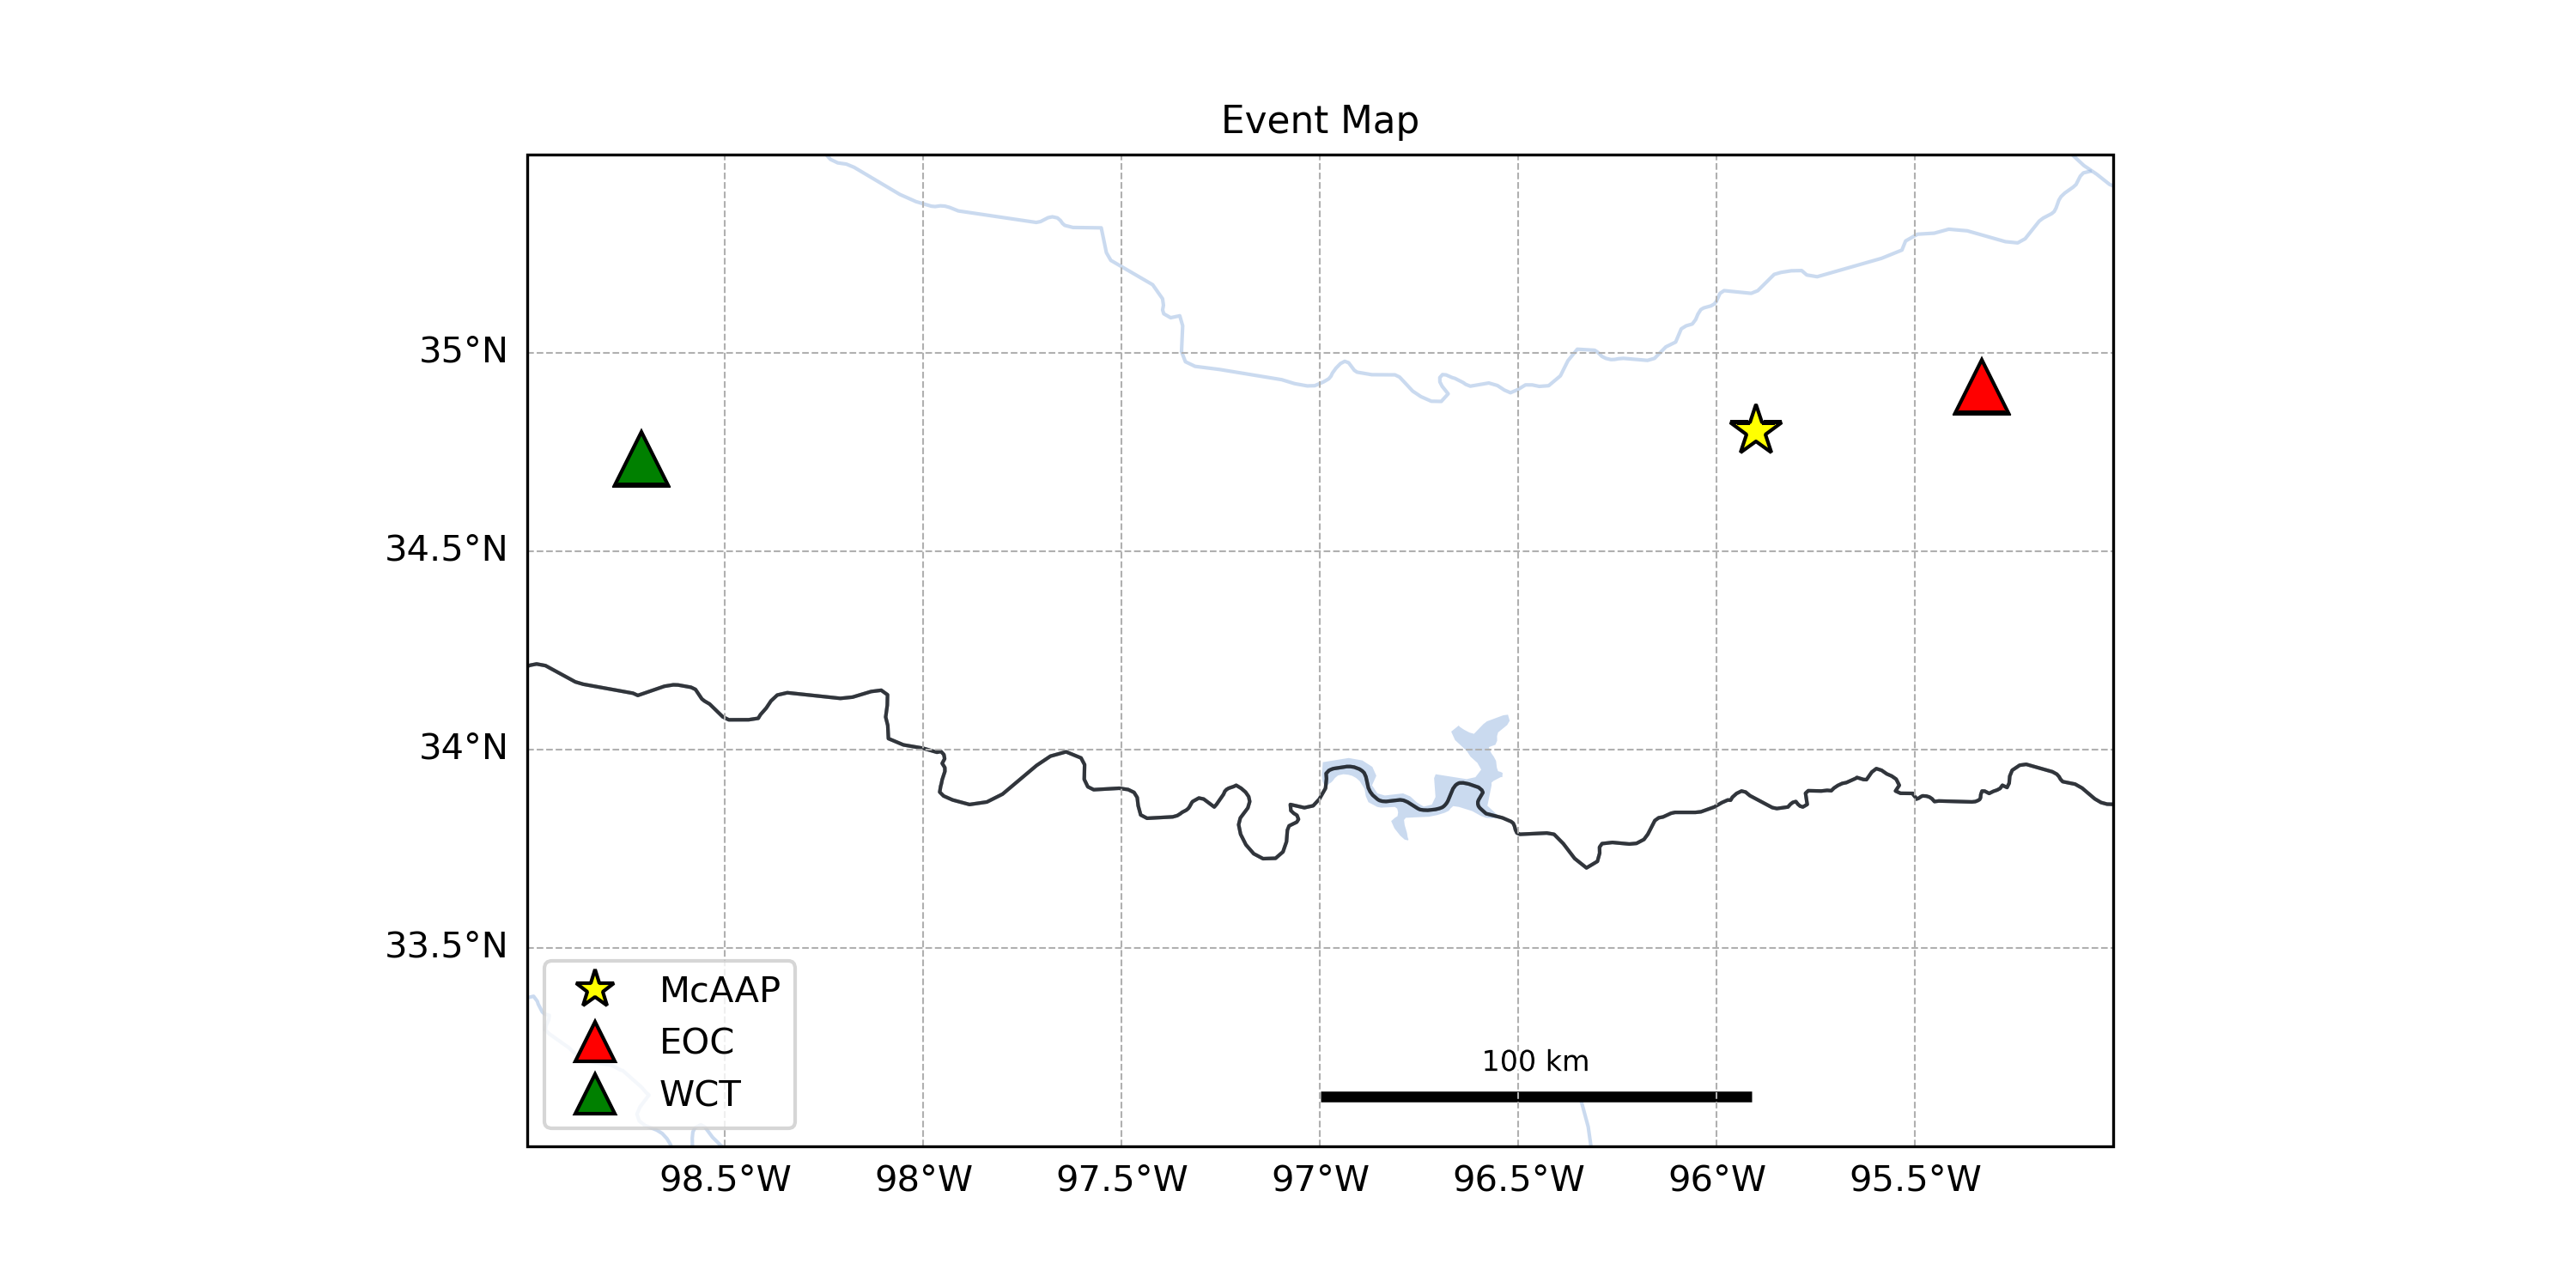

In [48]:
source_lon=-95.902050; source_lat=34.802819
generate_map(source_lat, source_lon, EOC_coords=[st_EOC[0].stats.sac.stlo,st_EOC[0].stats.sac.stla], WCT_coords=[st_WCT[0].stats.sac.stlo,st_WCT[0].stats.sac.stla], 
             extent=[-99, -95, 35.5, 33], markersize=15, markerscale=0.75, legend_fontsize=10, figsize=(10,5), title='Event Map')

Text(0.5, 1.0, 'MCA Coordinates')

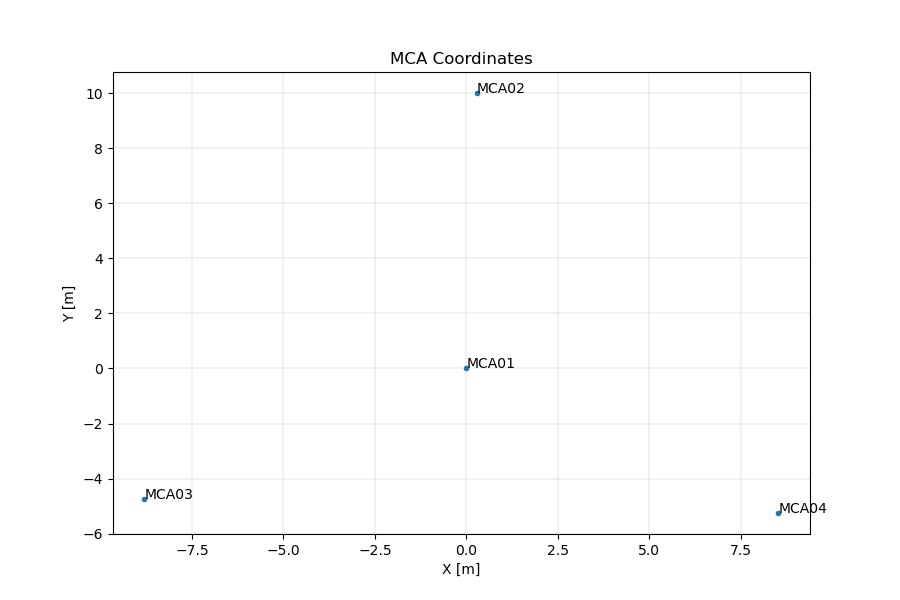

In [27]:
ref_station = st_MCA[0].stats.station
X, stnm = cardinal.get_array_coords(st_MCA, ref_station, units='m')
cardinal.plot_array_coords(X, stnm, units='m')
plt.title('MCA Coordinates')

Text(0.5, 1.0, 'MCB Coordinates')

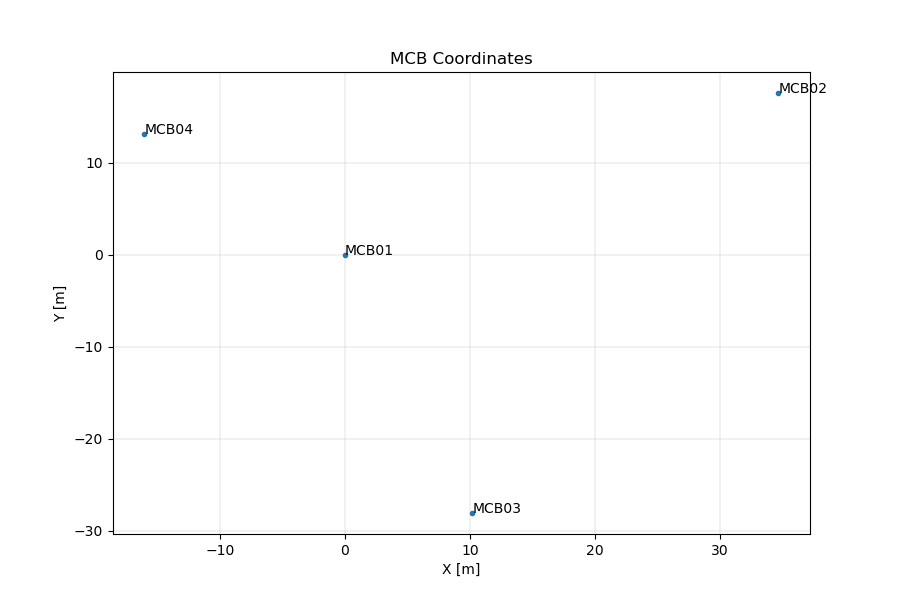

In [28]:
ref_station = st_MCB[0].stats.station
X, stnm = cardinal.get_array_coords(st_MCB, ref_station, units='m')
cardinal.plot_array_coords(X, stnm, units='m')
plt.title('MCB Coordinates')

Text(0.5, 1.0, 'EOCR Coordinates')

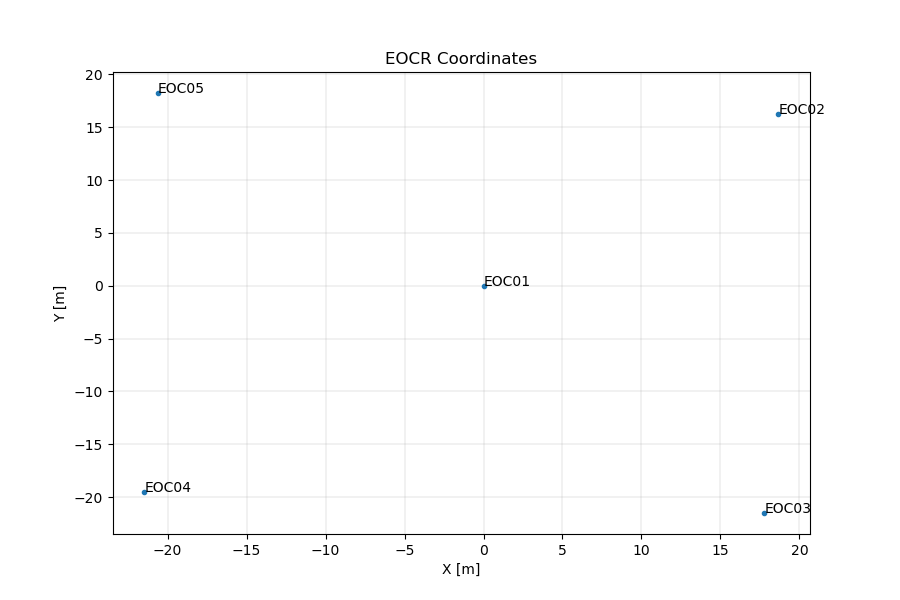

In [29]:
ref_station = st_EOC[0].stats.station
X, stnm = cardinal.get_array_coords(st_EOC, ref_station, units='m')
cardinal.plot_array_coords(X, stnm, units='m')
plt.title('EOCR Coordinates')

In [37]:
%%time
# Need to modify station names for EOCL
for idx in range(len(st_EOCL)):
    st_EOCL[idx].stats.station = st_EOCL[idx].stats.station + st_EOCL[idx].stats.location

CPU times: user 101 μs, sys: 353 μs, total: 454 μs
Wall time: 460 μs


Text(0.5, 1.0, 'EOCL Coordinates')

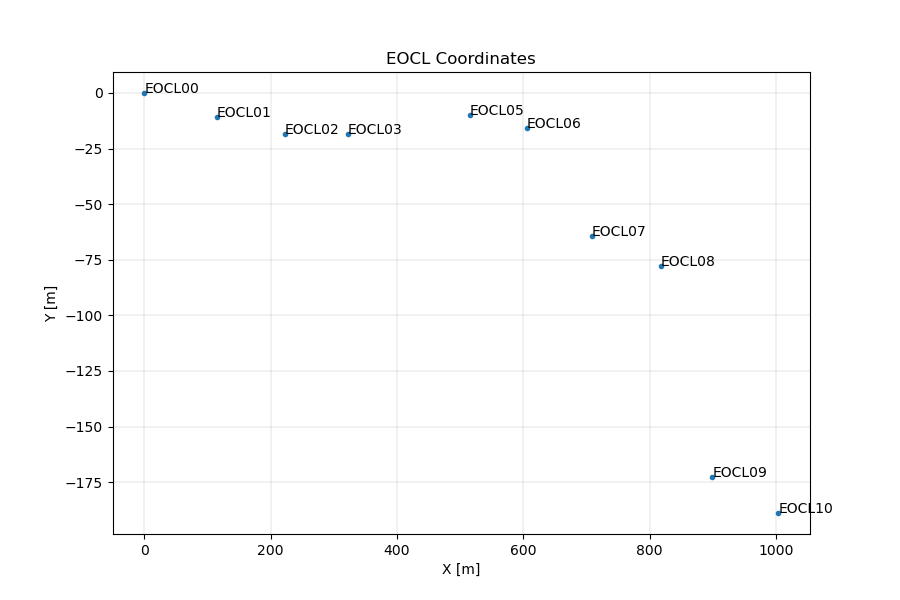

In [39]:
ref_station = st_EOCL[0].stats.station
X, stnm = cardinal.get_array_coords(st_EOCL, ref_station, units='m')
cardinal.plot_array_coords(X, stnm, units='m')
plt.title('EOCL Coordinates')

In [41]:
%%time
# Need to remove WCT01 - didn't use it bc too many impulsive noise segments
st_WCT = Stream([tr for tr in st_WCT if tr.stats.station != "WCT01"])

CPU times: user 70 μs, sys: 356 μs, total: 426 μs
Wall time: 433 μs


Text(0.5, 1.0, 'WCT Coordinates')

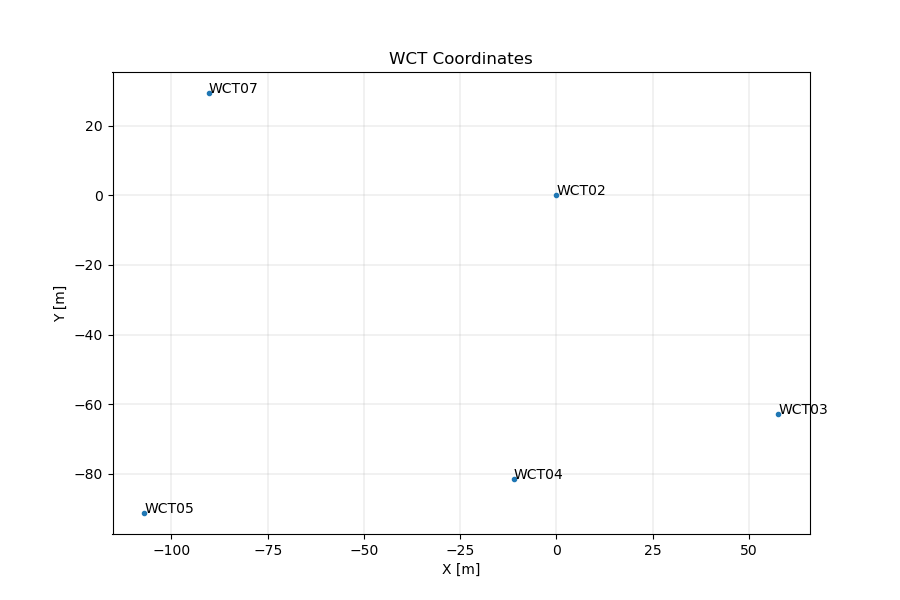

In [42]:
ref_station = st_WCT[0].stats.station
X, stnm = cardinal.get_array_coords(st_WCT, ref_station, units='m')
cardinal.plot_array_coords(X, stnm, units='m')
plt.title('WCT Coordinates')